### QUANT627 - Financial Econometrics Midterm
*Author: Augustin Valery, Leopold Dessane, Arthur Polini*

--------------------------------------------------------------------<br>
Name and exact ticker : The Walt Disney Company - DIS<br>
Length of the sample : 15857 trading days, 756 months , 63 years<br>
Initial date : 02/01/1962<br>
Final date : 30/12/2024<br>
Stock Market : New York Stock Exchange<br>
Country : United States<br>
--------------------------------------------------------------------<br>

In [281]:
# Install Yahoo Finance and Statsmodels libraries
!pip install yfinance statsmodels

In [319]:
# Import repository (packages/libraries/modules)
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
import scipy.signal as ss
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import lilliefors
import pylab
import seaborn as sns

##### Load data and transformation

In [283]:
# Retreiving data from Yahoo Finance
DIS = yf.download("DIS", start="1951-12-31", end="2024-12-31", auto_adjust=False)
DIS.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS,DIS
Date,,,,,,
1962-01-02,0.057441,0.092908,0.096026,0.092908,0.092908,841958
1962-01-03,0.058212,0.094155,0.094467,0.092908,0.092908,801865
1962-01-04,0.058212,0.094155,0.094467,0.093532,0.094155,962238
1962-01-05,0.058405,0.094467,0.094779,0.093844,0.094155,962238
1962-01-08,0.058212,0.094155,0.095714,0.092285,0.094467,1282984


In [ ]:
# Compute daily adjusted closing prices
Pt_daily_all = DIS["Adj Close"]
Pt_daily_all = Pt_daily_all.rename(columns={Pt_daily_all.columns[0]: "Pt.d"})
Pt_daily_all.set_index(pd.to_datetime(Pt_daily_all.index))

# Compute closing log prices
pt_daily_all = np.log(Pt_daily_all["Pt.d"])
pt_weekly_all = pt_daily_all.resample('W').last()
pt_monthly_all = pt_daily_all.resample('ME').last()
pt_yearly_all = pt_daily_all.resample('YE').last()
# Rename series
pt_daily_all.name, pt_weekly_all.name, pt_monthly_all.name, pt_yearly_all.name = "pt.d.all", "pt.w.all", "pt.m.all", "pt.y.all"

pt_daily_all.head()

Date
1962-01-02   -2.856999
1962-01-03   -2.843667
1962-01-04   -2.843667
1962-01-05   -2.840359
1962-01-08   -2.843667
Name: pt.d.all, dtype: float64

In [285]:
# Compute log returns
rt_daily_all = pt_daily_all.diff().dropna()
rt_weekly_all = pt_weekly_all.diff().dropna()
rt_monthly_all = pt_monthly_all.diff().dropna()
rt_yearly_all = pt_yearly_all.diff().dropna()
# Rename series
rt_daily_all.name, rt_weekly_all.name, rt_monthly_all.name, rt_yearly_all.name = "rt.d.all", "rt.w.all", "rt.m.all", "rt.y.all"

rt_daily_all.head()

Date
1962-01-03    0.013332
1962-01-04    0.000000
1962-01-05    0.003308
1962-01-08   -0.003308
1962-01-09    0.019677
Name: rt.d.all, dtype: float64

In [ ]:
# Define sample interval
ts_start_date = pd.to_datetime('1961-01-02')
ts_end_date = pd.to_datetime('2024-12-30')

# Select the interval on the time series
Pt_daily = Pt_daily_all.loc[ts_start_date:ts_end_date]
pt_daily = pt_daily_all.loc[ts_start_date:ts_end_date]
pt_weekly = pt_weekly_all.loc[ts_start_date:ts_end_date]
pt_montly = pt_monthly_all.loc[ts_start_date:ts_end_date]
rt_daily = rt_daily_all.loc[ts_start_date:ts_end_date]
rt_weekly = rt_weekly_all.loc[ts_start_date:ts_end_date]
rt_monthly = rt_monthly_all.loc[ts_start_date:ts_end_date]
rt_yearly = rt_yearly_all.loc[ts_start_date:ts_end_date]

rt_daily.head(20)


np.float64(0.0)

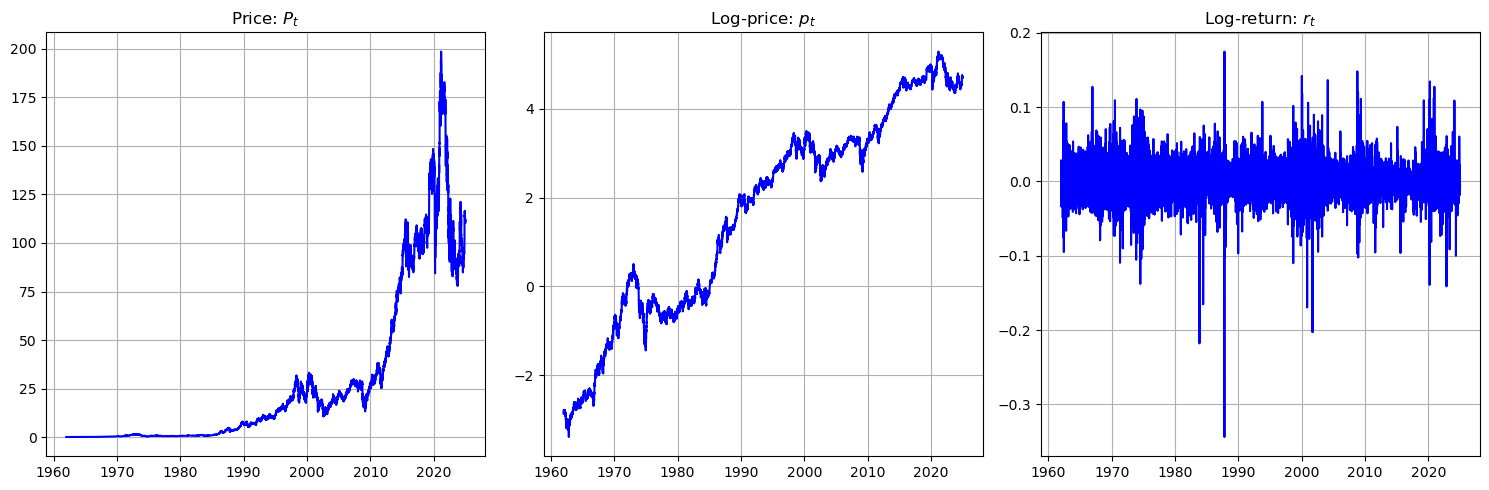

In [287]:
# Create a plot summary of the prices and returns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Daily prices
axs[0].plot(Pt_daily.index, Pt_daily, color='blue')
axs[0].set_title('Price: $P_t$')
axs[0].grid(True)
# Daily log prices
axs[1].plot(pt_daily.index, pt_daily, color='blue')
axs[1].set_title('Log-price: $p_t$')
axs[1].grid(True)
# Daily log-returns
axs[2].plot(rt_daily.index, rt_daily, color='blue')
axs[2].set_title('Log-return: $r_t$')
axs[2].grid(True)

# Adjust layout and plot
plt.tight_layout()
plt.show()

In [347]:
# Add descriptive table

# Define log returns sources
rt = {
    "Daily": rt_daily,
    "Weekly": rt_weekly,
    "Monthly": rt_monthly,
    "Annual": rt_yearly
}

# Create statistics computation function
def statistics(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab

STATS = pd.DataFrame({key: statistics(data.iloc[1:]) for key, data in rt.items()})

STATS

,Daily,Weekly,Monthly,Annual
Mean,0.04760,0.22915,1.01078,12.05865
St.Deviation,1.98470,4.24553,8.90574,31.49698
Diameter.C.I.Mean,0.03089,0.14518,0.63610,7.96984
Skewness,-0.38817,-0.23998,-0.46592,-0.78918
Kurtosis,12.31742,3.18087,2.66640,1.75432
Excess.Kurtosis,9.31742,0.18087,-0.33360,-1.24568
Min,-34.38215,-27.72759,-47.67279,-91.84049
Quant5,-2.90393,-6.20494,-13.42005,-34.96724
Quant25,-0.96000,-2.14509,-3.95659,-0.65490
Median,0.00000,0.18645,1.38349,12.96798


#### Stylized Fact 1: Prices are non-stationary

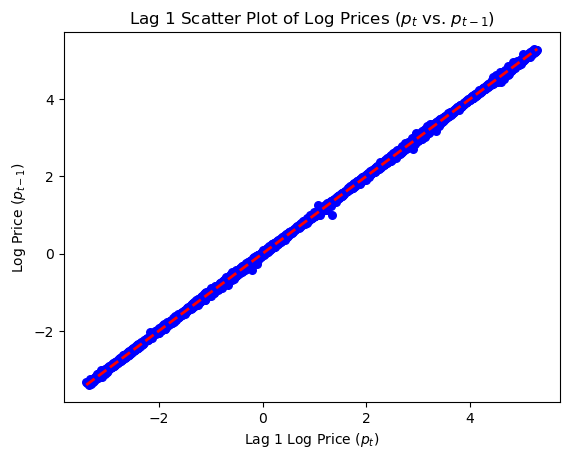

In [289]:
# TEST 1: Lag-1 scatter plot of log-returns

# Define lagged time series
pt_daily_lag1 = pt_daily.shift(1)

# Define the lag1_scatterplot function
plt.scatter(pt_daily_lag1, pt_daily, color='blue', s=30)
plt.plot([min(pt_daily), max(pt_daily)], [min(pt_daily), max(pt_daily)], linestyle='dashed', linewidth=2, color='red') 
plt.xlabel("Lag 1 Log Price ($p_t$)")
plt.ylabel("Log Price ($p_{t-1}$)")
plt.title("Lag 1 Scatter Plot of Log Prices ($p_t$ vs. $p_{t-1}$)")
plt.show()

In [290]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(pt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH0: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H0: δ < 0 (no unit root, stationary)
-----
ADF                    -1.477324
p-value                 0.544698
Critical Value (1%)    -3.430763
Critical Value (5%)    -2.861722
Critical Value (10%)   -2.566867
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely non-stationary.


In [291]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(pt_daily, regression='c')
print(kpss_results)

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH0: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

(np.float64(19.95824956314392), np.float64(0.01), 75, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
H0: Var(u) = 0 (no white noise, stationary)
H0: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    19.95825
p-value                  0.01000
Critical Value (1%)      0.73900
Critical Value (5%)      0.46300
Critical Value (10%)     0.34700
dtype: float64
-----
Reject the null hypothesis, the time series is likely non-stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_68275/2256628285.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_results = kpss(pt_daily, regression='c')


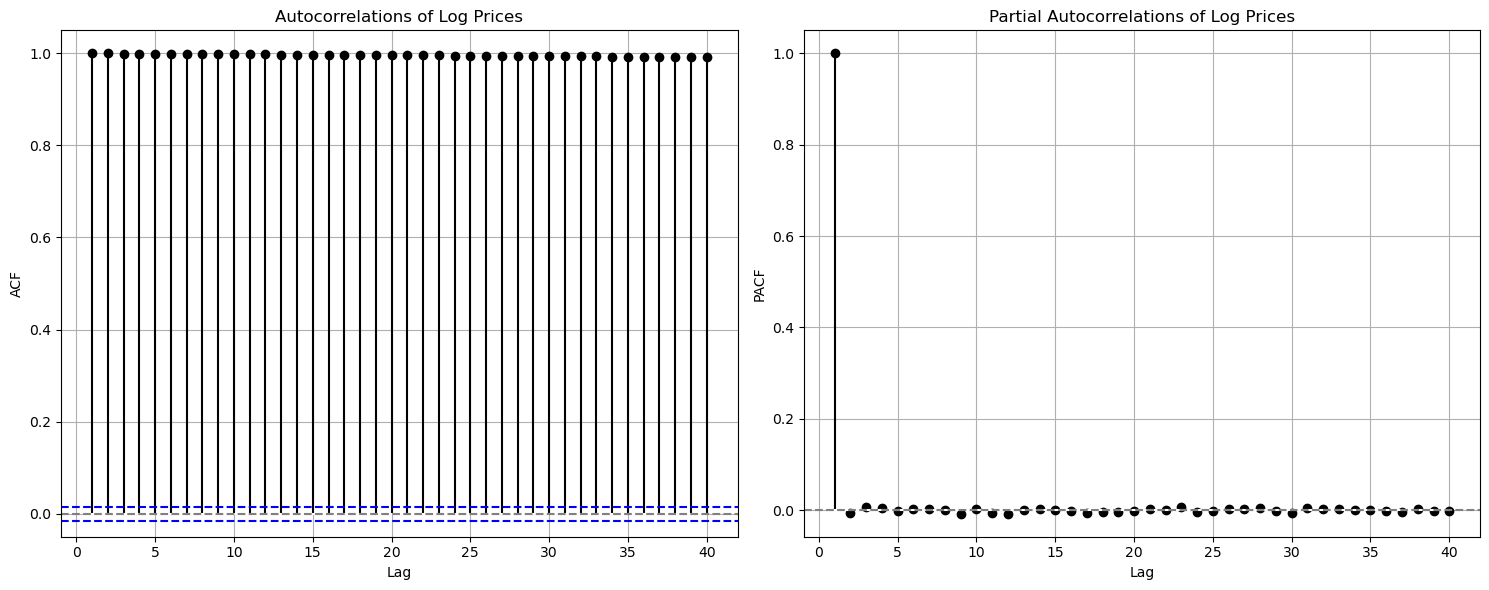

In [292]:
# TEST 4: Autocorrelation function and Partial Autocorrelation Function
lags = 40
conf_value = 1.96
acf_values = acf(pt_daily, nlags=lags)
pacf_values = pacf(pt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(pt_daily))

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

# ACF (Autocorrelation Function)
axs[0].stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].axhline(y=bartlett, color='blue', linestyle='--')
axs[0].axhline(y=-bartlett, color='blue', linestyle='--')
axs[0].set_title('Autocorrelations of Log Prices')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)

# PACF (Partial Autocorrelation Function)
axs[1].stem(np.arange(1, lags + 1), pacf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title('Partial Autocorrelations of Log Prices')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Stylized Fact 2: Returns are stationary

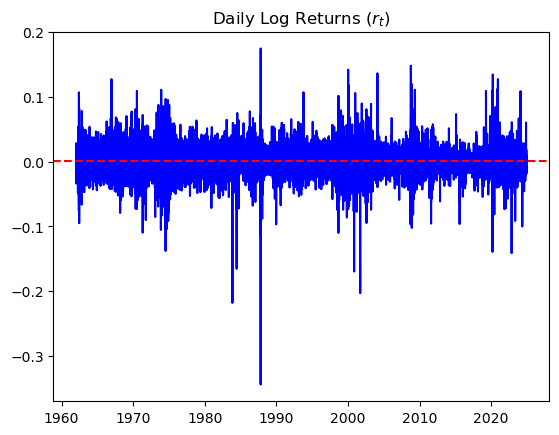

In [293]:
# TEST 1: Lag-1 scatter plot of log-returns

plt.plot(rt_daily, color='blue')
plt.axhline(y=rt_daily.mean(), color="red",linestyle='dashed', linewidth=1.5)
plt.title("Daily Log Returns ($r_t$)")
plt.show()

In [294]:
# TEST 2: Augmented Dickey-Fuller (ADF) test

# Test results
adf_result = adfuller(rt_daily)
ADF = pd.Series({
    "ADF": adf_result[0],
    "p-value": adf_result[1],
    "Critical Value (1%)": adf_result[4]['1%'],
    "Critical Value (5%)": adf_result[4]['5%'],
    "Critical Value (10%)": adf_result[4]['10%']
})

print(f"H0: δ = 0 (unit root, non-stationary)\nH0: δ < 0 (no unit root, stationary)\n-----\n{ADF}\n-----")

if ADF["p-value"] > 0.05 and ADF["ADF"] > ADF["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely non-stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely stationary.")

H0: δ = 0 (unit root, non-stationary)
H0: δ < 0 (no unit root, stationary)
-----
ADF                    -74.819335
p-value                  0.000000
Critical Value (1%)     -3.430763
Critical Value (5%)     -2.861722
Critical Value (10%)    -2.566867
dtype: float64
-----
Reject the null hypothesis, the time series is likely stationary.


In [318]:
# TEST 3: Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

kpss_results = kpss(rt_daily, regression='c')
print(kpss_results)

KPSS = pd.Series({
    "KPSS": kpss_results[0],
    "p-value": kpss_results[1],
    "Critical Value (1%)": kpss_results[3]['1%'],
    "Critical Value (5%)": kpss_results[3]['5%'],
    "Critical Value (10%)": kpss_results[3]['10%']
})

print(f"H0: Var(u) = 0 (no white noise, stationary)\nH1: Var(u) > 0 (white noise, non stationary)\n-----\n{KPSS}\n-----")

if KPSS["p-value"] > 0.05 and KPSS["KPSS"] < KPSS["Critical Value (10%)"]:
    print("Fail to reject the null hypothesis, the time series is likely stationary.")
else : 
    print("Reject the null hypothesis, the time series is likely non-stationary.")

(np.float64(0.12996452728629812), np.float64(0.1), 0, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
H0: Var(u) = 0 (no white noise, stationary)
H1: Var(u) > 0 (white noise, non stationary)
-----
KPSS                    0.129965
p-value                 0.100000
Critical Value (1%)     0.739000
Critical Value (5%)     0.463000
Critical Value (10%)    0.347000
dtype: float64
-----
Fail to reject the null hypothesis, the time series is likely stationary.


/var/folders/z6/j_nqb41d7p71wfmbz0m97p200000gn/T/ipykernel_68275/3665203255.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_results = kpss(rt_daily, regression='c')


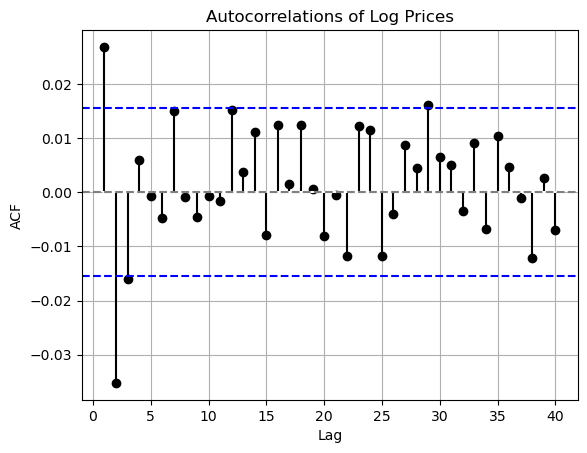

In [296]:
# TEST 4: Autocorrelation function and Partial Autocorrelation Function
lags = 40
conf_value = 1.96
acf_values = acf(rt_daily, nlags=lags)

#Bartlett intervals for ACF
bartlett = conf_value / np.sqrt(len(rt_daily))

# ACF (Autocorrelation Function)
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=bartlett, color='blue', linestyle='--')
plt.axhline(y=-bartlett, color='blue', linestyle='--')
plt.title('Autocorrelations of Log Prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

#### Stylized Fact 3: Returns are asymmetric (negative skewness)


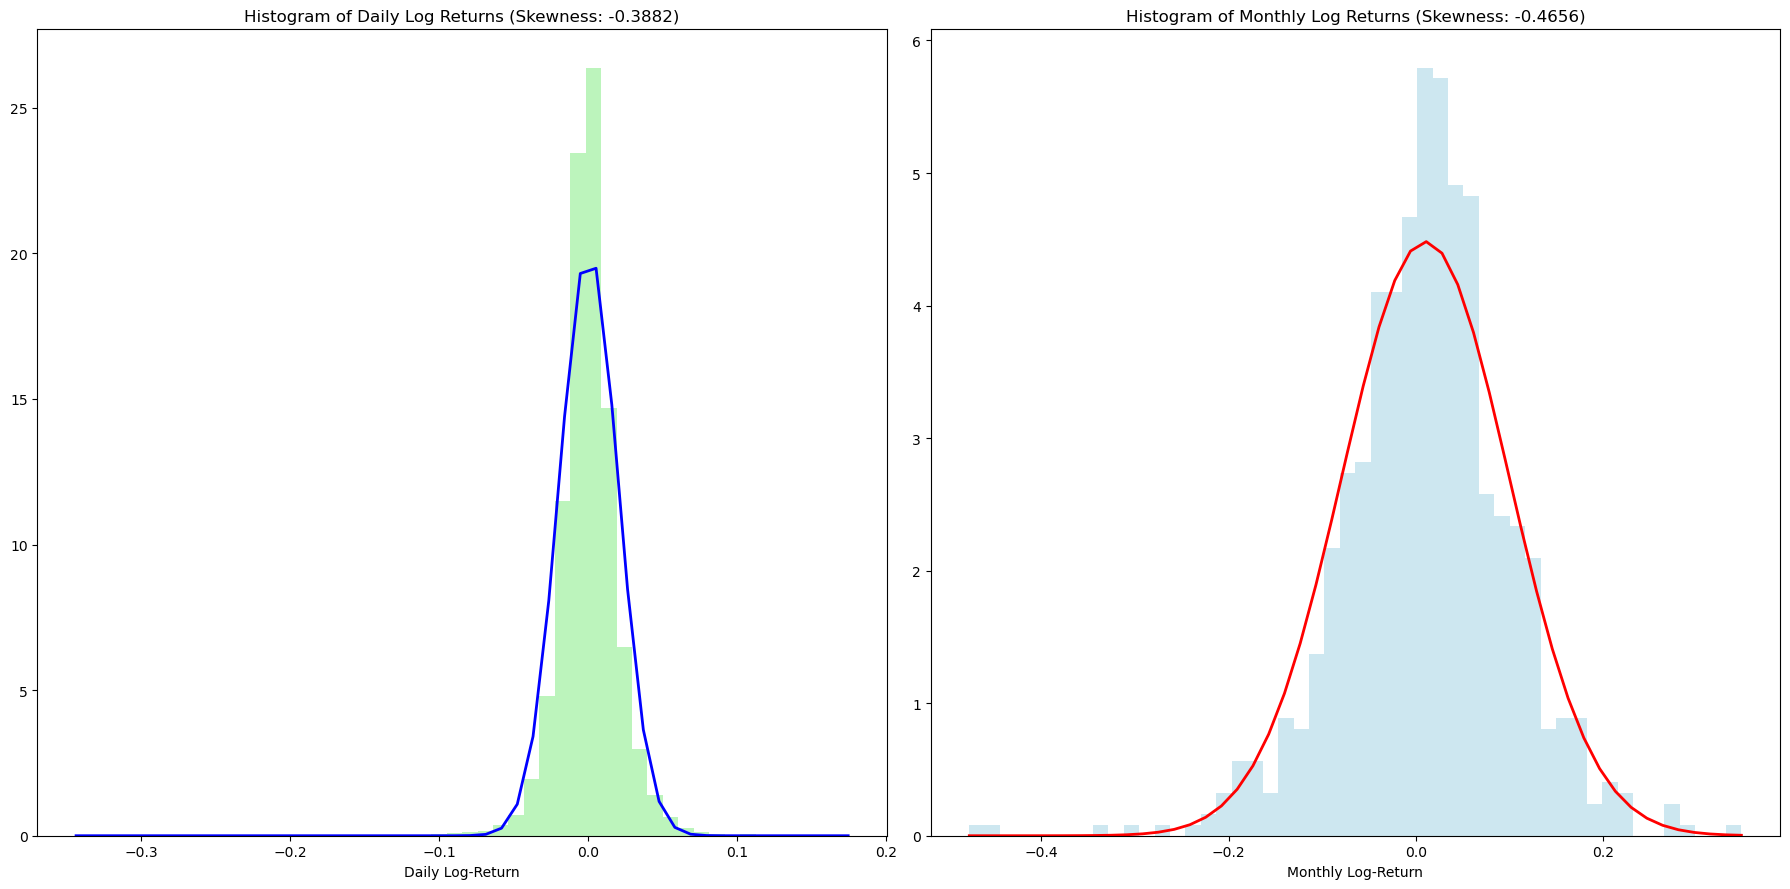

Daily log returns skewness: -0.38817
Monthly log returns skewness: -0.46561057548750184


In [ ]:
# TEST 1: Histogram and skewness versus normal distribution

# Skewness computation
skew_daily = stats.skew(rt_daily) ### REMPLACER PAR la valeur calculé dans le tableau descriptif
skew_monthly = stats.skew(rt_monthly) ### REMPLACER PAR la valeur calculé dans le tableau descriptif

# Theoretical normal distributions
normal_daily = stats.norm.pdf(np.linspace(rt_daily.min(),rt_daily.max()), loc=np.mean(rt_daily), scale=np.std(rt_daily))
normal_monthly = stats.norm.pdf(np.linspace(rt_monthly.min(),rt_monthly.max()), loc=np.mean(rt_monthly),scale=np.std(rt_monthly))

# Plotting histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].hist(rt_daily, bins=50, density=True, color="lightgreen",alpha=0.6)
axs[0].plot(np.linspace(rt_daily.min(), rt_daily.max()),normal_daily, color="blue", linewidth=2)
axs[0].set_xlabel("Daily Log-Return")
axs[0].set_title(f"Histogram of Daily Log Returns (Skewness: {skew_daily:.4f})")

axs[1].hist(rt_monthly, bins=50, density=True, color="lightblue",alpha=0.6)
axs[1].plot(np.linspace(rt_monthly.min(), rt_monthly.max()),normal_monthly, color="red", linewidth=2)
axs[1].set_xlabel("Monthly Log-Return")
axs[1].set_title(f"Histogram of Monthly Log Returns (Skewness: {skew_monthly:.4f})")

plt.tight_layout()
plt.show()

print(f"Daily log returns skewness: {skew_daily}\nMonthly log returns skewness: {skew_monthly}")

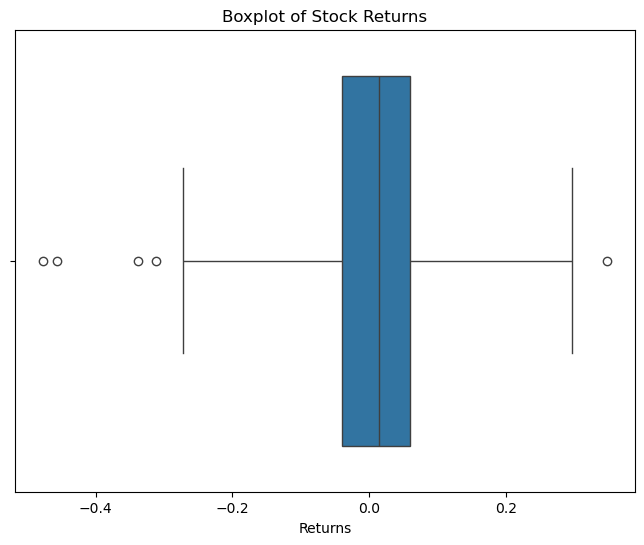

Median relative to mean of daily log returns: -0.0036439130861107786


In [315]:
# Test 2: Boxplot and median

excess_median = rt_monthly.mean() - rt_monthly.median() # REMPLACER PAR VALEUR DU TABLEAU

plt.figure(figsize=(8, 6))
sns.boxplot(x=rt_monthly,whis=2.5)
plt.title('Boxplot of Stock Returns')
plt.xlabel('Returns')
plt.show()

print(f'Median relative to mean of daily log returns: {excess_median}')

In [329]:
# Test 3: Jarque-Bera test

# Jarque-Bera test to check for skewness and kurtosis
jarque_bera_results = stats.jarque_bera(rt_monthly)
JB = pd.Series({
    "JB": round(jarque_bera_results[0], 4),
    "p-value": jarque_bera_results[1]
})

print(f"H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)\nH1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)\n-----\n{JB}\n-----")

if JB["p-value"] > 0.05:
    print("Fail to reject the null hypothesis, the returns skewness and tails are not significantly different from those of a normal distribution.")
else : 
    print("Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.")

H0: Skew = 0 and Kurt = 3 (normality of skewness and tails)
H1: Skew ≠ 0 and/or Kurt ≠ 3 (non-normality of skewness and tails)
-----
JB         2.517492e+02
p-value    2.154573e-55
dtype: float64
-----
Reject the null hypothesis, the returns skewness and/or tails are significantly different from those of a normal distribution.


In [ ]:
# Test 4: D'Agostino test (1970)